## Overfit Artificial Neural Network

#### **Emmanuel Ikpesu**
#### **Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering**
##### [LinkedIn](https://www.linkedin.com/in/emmanuel-ikpesu-393708132/)

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

* What is the gap, problem, opportunity, scientific question?

* What was done to address the above?

* What was learned?

* What are your recommendations?

**Guidance**: Write as a single paragraph with 4 or so well-writen sentences.

### Import Packages
>  Below are the packages utilized for building this workflow.

In [ ]:
%matplotlib inline
import numpy as np                                      # arrays and matrix math
import matplotlib.pyplot as plt                         # plotting
from sklearn.model_selection import train_test_split    # train and test split
from sklearn.metrics import mean_squared_error          # model error calculation
from sklearn.preprocessing import StandardScaler        # standardize data
import scipy                                            # kernel density estimator for PDF plot


# build deep learning models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta


from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')                       # supress warnings

In [ ]:
nreal  = 4
seed = 42
np.random.seed(seed)                                   # set seed for reproducibility
 
activation_functions_list = ['linear', 'relu', 'sigmoid', 'softmax', 'gelu']
reduce_nodes_list = [True, False]
node_sizes_list = [1, 2, 4, 8, 16, 32, 64, 128]
num_layers_list = [1, 2, 3, 4, 5]
dropout_rates_list = [0.0, 0.01, 0.03, 0.05, 0.075, 0.1, 0.2, 0.3]
epochs_list = np.logspace(0, 3, num=4).astype(int)  # 5 epochs from 1 to 5
learning_rates_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
batch_sizes_list = [1, 2, 4, 8, 16, 32]
optimizers_list = ['SGD', 'Adam', 'Adadelta', 'RMSprop']

In [ ]:

title = widgets.Text(value='                                                                                            Artificial Neural Networked Overfitting Demo, Emmanuel Ikpesu, The University of Texas at Austin',
                 layout=Layout(width='1280px', height='30px'))

# data parameters
title_left = widgets.HTML(value="<b>📊 Data Parameters</b>")
n = widgets.IntSlider(min=15, max=80, value=30, step=1, description='Data Size (n)', style={'description_width': 'initial'})
split = widgets.FloatSlider(min=0.05, max=0.95, value=0.20, step=0.05, description='Test Split %', style={'description_width': 'initial'})
std = widgets.FloatSlider(min=0, max=50, value=0, step=1.0, description='Noise StDev', style={'description_width': 'initial'})



# Input layer parameters
title_input = widgets.HTML(value="<b>📥 Input Layer</b>")
input_activation = widgets.Dropdown(options=activation_functions_list,
                                       value='relu', description='Activation')
input_nodes = widgets.Dropdown(options=node_sizes_list, value=64, description='Nodes Per Layer')

title_hidden = widgets.HTML(value="<b>🤖 Hidden Layers</b>")
hidden_activation = widgets.Dropdown(options=activation_functions_list,
                                       value='relu', description='Activation')
reduce_nodes = widgets.ToggleButtons(options=reduce_nodes_list, value=True, description='Reduce Nodes')
hidden_nodes = widgets.Dropdown(options=node_sizes_list, value=64, description='Nodes Per Layer')
num_hidden_layers = widgets.IntSlider(min=1, max=4, value=2, step=1, description='Num Hidden Layers')
dropout_rate = widgets.FloatSlider(min=0.0, max=0.3, value=0.1, step=0.1, description='Dropout Rate')

# ANN hyperparameters
title_ann = widgets.HTML(value="<b>🧠 ANN Parameters</b>")
epochs = widgets.Dropdown(options=epochs_list, value=10, description='Epochs')
learning_rate = widgets.Dropdown(options=learning_rates_list, value=0.001, description='Learning Rate')
batch_size = widgets.Dropdown(options=batch_sizes_list, value=16, description='Batch Size')
optimizer = widgets.Dropdown(options=optimizers_list, value='Adam', description='Optimizer')

data_column = widgets.VBox([title_left, n, split, std])
input_column = widgets.VBox([title_input, input_activation, input_nodes])
hidden_column = widgets.VBox([title_hidden, hidden_activation, hidden_nodes, num_hidden_layers, dropout_rate, reduce_nodes])
ann_column = widgets.VBox([title_ann, epochs, learning_rate, batch_size, optimizer])

model_details = widgets.Text(value=f'''                                                             The ANN Model Currently have {num_hidden_layers.value} 
Hidden Layers, Epoch of {epochs.value}, & {learning_rate.value} Learning Rate. For more details, please check the bottons above.''',
                            
                              
                 layout=Layout(width='1280px', height='30px'))
# Combine into two-column layout
ui = HBox([data_column, input_column, hidden_column, ann_column])
ui2 = VBox([title, ui, model_details])
# Display the UI
display(ui2)


In [62]:
def data_generator(n: int, std: float, seed: int):
    """
    Generates a synthetic dataset based on a polynomial function with added noise.
    
    Parameters:
    - n (int): Number of data points.
    - split (float): Proportion of the dataset to include in the test split (e.g., 0.2 for 20% test data).
    - std (float): Standard deviation of the Gaussian noise added to the data.
    - seed (int): Random seed for reproducibility.
    
    Returns:
    - X (array): Predictor feature values.
    - y (array): Target values (response variable).
    """
    
    np.random.seed(seed)  # Seed the random number generator for reproducibility

    # Generate dataset
    X_seq = np.linspace(0, 20, 100)  # Sequence for plotting
    X = np.random.rand(n) * 20  # Generate random X values within the range [0, 20]
    
    # Create polynomial target values (quadratic function in this case)
    y = X ** 2 + 50.0  
    
    # Add Gaussian noise to the target variable
    y += np.random.normal(loc=0.0, scale=std, size=n)

    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X.reshape(-1, 1)).flatten()

    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    return X_scaled, y_scaled, X_scaler, y_scaler



def split_data(X, y, test_size=0.2, seed=42, realization=0):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    - X (array-like): Feature matrix.
    - y (array-like): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - seed (int): Random seed for reproducibility.
    - realization (int): Value added to the seed for multiple realizations.

    Returns:
    - X_train, X_test, y_train, y_test: Split training and testing datasets.
    """

    return train_test_split(X, y, test_size=test_size, random_state=seed + realization)

In [63]:
def input_layer(nodes: int, activation_function: str):
    """
    Creates an input layer for a neural network.

    Parameters:
    nodes (int): Number of neurons in the input layer.
    activation_function (str): Activation function to be used in the input layer.

    Returns:
    Dense: A Keras Dense layer with the specified number of nodes and activation function.
    """
    return Dense(nodes, activation=activation_function, input_shape=(1,))


def hidden_layer(nodes: int, activation_function: str):
    """
    Creates a hidden layer for a neural network.

    Parameters:
    nodes (int): The number of neurons in the hidden layer.
    activation_function (str): The activation function to be applied to the layer.

    Returns:
    Dense: A Keras Dense layer with the specified number of neurons and activation function.

    Example:
    >>> layer = hidden_layer(10, 'relu')
    >>> print(layer)
    <keras.src.layers.core.dense.Dense object at 0x...>
    """
    return Dense(nodes, activation=activation_function)


def output_layer():
    """
    Creates an output layer for a neural network.

    Returns:
    Dense: A Keras Dense layer with one neuron and a linear activation function.
    """
    return Dense(1, activation='linear')


def create_hidden_layers(model, num_layers: int, start_nodes: int, reduce_nodes: bool, activation_function: str, dropout_rate: float):
    """
    Adds hidden layers to a model with the option to either reduce or keep constant the number of neurons.

    Parameters:
    - model (Sequential): The Keras Sequential model to which the layers will be added.
    - num_layers (int): Number of hidden layers to add.
    - start_nodes (int): The number of neurons in the first hidden layer.
    - reduce_nodes (bool): If True, the number of neurons will decrease in each layer.
    - activation_function (str): The activation function to use for the hidden layers.

    Returns:
    - model (Sequential): The updated Keras Sequential model with added hidden layers.
    """
    
    for i in range(num_layers):
        if reduce_nodes:
            # Decrease the number of neurons by half in each layer
            nodes = max(1, int(start_nodes / (2 ** i)))  # Avoid going below 1 neuron
        else:
            # Keep the number of neurons constant
            nodes = start_nodes

        model.add(hidden_layer(nodes, activation_function))
        model.add(Dropout(dropout_rate))  # Add dropout layer
        # Add a dropout layer after each hidden layer

    return model


def build_model(input_nodes: int, input_activation: str,
                num_hidden_layers: int, hidden_nodes: int, reduce_nodes: bool = True, hidden_activation: str = 'relu', dropout_rate: float = 0.0,
                optimizer: str = 'adam', learning_rate: float = 0.01):
    
    """
    Builds a customizable neural network model using the Sequential API.

    This function creates a neural network model with a specified number of hidden layers, 
    customizable hidden node sizes (with an option for reducing nodes), activation functions, 
    and dropout regularization.

    Parameters:
    ----------
    input_nodes : int
        The number of nodes in the input layer.
    
    input_activation : str
        The activation function for the input layer (e.g., 'ReLU', 'sigmoid', 'tanh').
    
    num_hidden_layers : int
        The number of hidden layers to be added to the model.
    
    hidden_nodes : int
        The number of nodes in the first hidden layer. The number of nodes in subsequent 
        layers will decrease if `reduce_nodes` is set to True.
    
    reduce_nodes : bool, default=True
        Whether to reduce the number of nodes in each subsequent hidden layer. If False, 
        all hidden layers will have the same number of nodes as the first hidden layer.
    
    hidden_activation : str, default='ReLU'
        The activation function for all hidden layers (e.g., 'ReLU', 'sigmoid', 'tanh').
    
    dropout_rate : float, default=0.0
        The dropout rate applied to the hidden layers to prevent overfitting. A value between 0 and 1.

    optimizer : str, default='adam'
        The optimizer to use for training the model. Options include 'adam', 'sgd', 'adadelta', and 'rmsprop'.

    learning_rate : float, default=0.01
        The learning rate for the optimizer. This controls how much to change the model in response to the estimated error each time the model weights are updated.

    Returns:
    -------
    model : keras.Sequential
        A compiled Sequential model ready to be trained.
    """

    model = Sequential()
    # Add the input layer
    model.add(input_layer(input_nodes, input_activation))
    # Add hidden layers
    model = create_hidden_layers(model, num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate)
    # Add the output layer
    model.add(output_layer())

    # Choose optimizer based on input
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'Adadelta':
        opt = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mean_squared_error')

    return model

def train_model(model, X_train, y_train, epochs: int = 10, batch_size: int = 32, val=False):
    """
    Trains the neural network model on the provided training data.

    Parameters:
    ----------
    model : keras.Sequential
        The compiled Keras model to be trained.
    
    X_train : np.ndarray
        The input features for training.
    
    y_train : np.ndarray
        The target variable for training.
    
    epochs : int, default=10
        The number of epochs to train the model.
    
    batch_size : int, default=32
        The size of the batches used in training.

    Returns:
    -------
    history : keras.callbacks.History
        A History object containing details about the training process.
    """

    if val:
        # Split the data into training and validation sets
        X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
        history = model.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(X_val, y_val))
        # Train the model with validation data
    else:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    return model, history



In [ ]:

n, split, std, input_nodes, input_activation, num_hidden_layers, hidden_nodes, \
reduce_nodes, hidden_activation, dropout_rate, optimizer, learning_rate, batch_size, epochs = 32, 0.25, 0, 64, 'relu', 2, 256, True, 'relu', 0.1, 'Adam', 0.001, 16, 100


X_scaled, y_scaled, X_scaler, y_scaler = data_generator(n, std, seed)


# Dictionary to store MSE results
mse_results = {
    'hidden_node_sizes': 
        {'train': np.zeros([len(node_sizes_list), nreal])
         ,'test': np.zeros([len(node_sizes_list), nreal])},
    'num_layers': 
        {'train': np.zeros([len(num_layers_list), nreal])
         ,'test': np.zeros([len(num_layers_list), nreal])},
    'dropout_rates': 
        {'train': np.zeros([len(dropout_rates_list), nreal])
         ,'test': np.zeros([len(dropout_rates_list), nreal])},
    'epochs_list': 
        {'train': np.zeros([len(epochs_list), nreal])
         ,'test': np.zeros([len(epochs_list), nreal])},
    'learning_rates': 
        {'train': np.zeros([len(learning_rates_list), nreal])
         ,'test': np.zeros([len(learning_rates_list), nreal])},
    'batch_sizes': 
        {'train': np.zeros([len(batch_sizes_list), nreal])
         ,'test': np.zeros([len(batch_sizes_list), nreal])}   
}

#---------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------Run Model Sensitivity----------------------------------------------------------
for j in range(nreal):
    # Split data for each realization
    X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled, split, seed, j)

    # Test different Hidden node sizes
    for i, nodes in enumerate(node_sizes_list):
        model = build_model(input_nodes, input_activation,
                num_hidden_layers, nodes, reduce_nodes, hidden_activation, dropout_rate,
                optimizer, learning_rate)
        model, history = train_model(model, X_train, y_train, epochs, batch_size)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_results['hidden_node_sizes']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
        mse_results['hidden_node_sizes']['test'][i, j] = mean_squared_error(y_test, y_test_pred)

    # Test different number of layers
    for i, layers in enumerate(num_layers_list):
        model = build_model(input_nodes, input_activation,
                layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                optimizer, learning_rate)
        model, history = train_model(model, X_train, y_train, epochs, batch_size)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_results['num_layers']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
        mse_results['num_layers']['test'][i, j] = mean_squared_error(y_test, y_test_pred)
        

    # Test different dropout rates
    for i, dropout in enumerate(dropout_rates_list):
        model = build_model(input_nodes, input_activation,
                num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout,
                optimizer, learning_rate)
        model, history = train_model(model, X_train, y_train, epochs, batch_size)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_results['dropout_rates']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
        mse_results['dropout_rates']['test'][i, j] = mean_squared_error(y_test, y_test_pred)


    # Test different number of epochs
    for i, epoch_value in enumerate(epochs_list):
        model = build_model(input_nodes, input_activation,
                num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                optimizer, learning_rate)
        model, history = train_model(model, X_train, y_train, epoch_value, batch_size)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_results['epochs_list']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
        mse_results['epochs_list']['test'][i, j] = mean_squared_error(y_test, y_test_pred)

    # Test different learning rates
    for i, lr in enumerate(learning_rates_list):
        model = build_model(input_nodes, input_activation,
                num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                optimizer, learning_rate)
        model, history = train_model(model, X_train, y_train, epochs, batch_size)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_results['learning_rates']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
        mse_results['learning_rates']['test'][i, j] = mean_squared_error(y_test, y_test_pred)

    # Test different batch sizes
    for i, batch in enumerate(batch_sizes_list):
        model = build_model(input_nodes, input_activation,
                num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                optimizer, learning_rate)
        model, history = train_model(model, X_train, y_train, epochs, batch)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_results['batch_sizes']['train'][i, j] = mean_squared_error(y_train, y_train_pred)
        mse_results['batch_sizes']['test'][i, j] = mean_squared_error(y_test, y_test_pred)


mse_summary = {}

for key, value in mse_results.items():
    mse_summary[key] = {}
    for subset in ['train', 'test']:
        mse_matrix = value[subset]
        mse_summary[key][subset] = {
            'mean': np.mean(mse_matrix, axis=1).flatten(),
            'high': np.percentile(mse_matrix, 90, axis=1),
            'low': np.percentile(mse_matrix, 10, axis=1)
        }


#---------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------Model Building and Training Required Mode----------------------------------------------

# build the one model example to show
X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled, split, seed, 0)
model = build_model(input_nodes, input_activation,
                num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate,
                optimizer, learning_rate)
model, history = train_model(model, X_train, y_train, epochs, batch_size, val=True)

# calculate error
y_train_pred = model.predict(X_train) # predict training data
y_test_pred = model.predict(X_test) # predict test data


error_train = y_train_pred.flatten() - y_train # calculate error on training data
error_test = y_test_pred.flatten() - y_test # calculate error on test data

# calculate model curve
X_seq = np.linspace(-3,3,100)
y_seq = model.predict(X_seq) # predict model curve


#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------Results Visualization--------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 21))
plt.subplot(331)
# Plot model predictions
X_train_true = X_scaler.inverse_transform(X_train.reshape(-1, 1)).flatten()
X_test_true = X_scaler.inverse_transform(X_test.reshape(-1, 1)).flatten()
y_train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
X_seq_true = X_scaler.inverse_transform(X_seq.reshape(-1, 1)).flatten()
y_seq_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
plt.plot(X_seq_true, y_seq_true, color="black", linewidth=2, label="ANN Prediction")
# Plot training and test data
plt.scatter(X_train_true, y_train_true, c="red", alpha=0.3, edgecolors="black", label="Training Data")
plt.scatter(X_test_true, y_test_true, c="blue", alpha=0.3, edgecolors="black", label="Test Data")
plt.title("Artificial Neural Network Model", fontsize=11) # Titles and labels
plt.xlabel("Porosity (%)", fontsize=10); plt.ylabel("Permeability (mD)", fontsize=10)
plt.xlim([0, 25]); plt.ylim([0, 500])
plt.grid(True, linestyle='--', alpha=0.5); plt.legend(frameon=True, loc='upper left')

plt.subplot(332)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ANN Training and Validation Loss", fontsize=11) # Titles and labels
plt.xlabel("Epoch", fontsize=10); plt.ylabel("Mean Squared Error", fontsize=10)
plt.xscale('log'); plt.yscale('log')
plt.grid(which='both',linestyle='--', alpha=0.5); plt.legend()


plt.subplot(333)
plt.hist(error_train, facecolor='red',alpha=0.2,density=True,edgecolor='black',label='Train')
plt.hist(error_test, facecolor='blue',alpha=0.2,density=True,edgecolor='black',label='Test')
plt.xlabel('Model Error', fontsize=10); plt.ylabel('Frequency', fontsize=10); 
plt.title('Training and Testing Error Distribution', fontsize=11)
plt.legend(loc='upper right'); plt.grid(which='both',linestyle='--', alpha=0.5)


plt.subplot(334)
epoch_summary = mse_summary['epochs_list']
train_avg = epoch_summary['train']['mean']; train_high = epoch_summary['train']['high']; train_low = epoch_summary['train']['low']
test_avg = epoch_summary['test']['mean']; test_high = epoch_summary['test']['high']; test_low = epoch_summary['test']['low']
ax = plt.gca()
plt.plot(epochs_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(epochs_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(epochs_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(epochs_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlim([1,10e2]); plt.xscale('log')
plt.ylim([1,10e4]); plt.yscale('log')
plt.xlabel('Complexity - No_of_epochs'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Epochs)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplot(335)
hidden_node_summary = mse_summary['hidden_node_sizes']
train_avg = hidden_node_summary['train']['mean']; train_high = hidden_node_summary['train']['high']; train_low = hidden_node_summary['train']['low']
test_avg = hidden_node_summary['test']['mean']; test_high = hidden_node_summary['test']['high']; test_low = hidden_node_summary['test']['low']
ax = plt.gca()
plt.plot(node_sizes_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(node_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(node_sizes_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(node_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - # Starting Hidden Node'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (# Hidden-Nodes)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplot(336)
num_layers_summary = mse_summary['num_layers']
train_avg = num_layers_summary['train']['mean']; train_high = num_layers_summary['train']['high']; train_low = num_layers_summary['train']['low']
test_avg = num_layers_summary['test']['mean']; test_high = num_layers_summary['test']['high']; test_low = num_layers_summary['test']['low']
ax = plt.gca()
plt.plot(num_layers_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(num_layers_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(num_layers_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(num_layers_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - # Hidden Layers'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (# Hidden-Layers)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplot(337)
dropout_rates_summary = mse_summary['dropout_rates']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
ax = plt.gca()
plt.plot(dropout_rates_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(dropout_rates_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(dropout_rates_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(dropout_rates_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - Dropout Rate'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Dropout Rate)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

plt.subplot(338)
dropout_rates_summary = mse_summary['learning_rates']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
ax = plt.gca()
plt.plot(learning_rates_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(learning_rates_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(learning_rates_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(learning_rates_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Complexity - Learning Rate'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Learning Rate)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

plt.subplot(339)
dropout_rates_summary = mse_summary['batch_sizes']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
ax = plt.gca()
plt.plot(batch_sizes_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(batch_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(batch_sizes_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(batch_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - Batch Size'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Batch Size)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.2, hspace=0.3)


plt.show()

Epoch 1/100
24/24 - 1s - 27ms/step - loss: 0.7443
Epoch 2/100
24/24 - 0s - 2ms/step - loss: 0.1384
Epoch 3/100
24/24 - 0s - 2ms/step - loss: 0.0606
Epoch 4/100
24/24 - 0s - 2ms/step - loss: 0.0692
Epoch 5/100
24/24 - 0s - 2ms/step - loss: 0.0859
Epoch 6/100
24/24 - 0s - 2ms/step - loss: 0.0799
Epoch 7/100
24/24 - 0s - 2ms/step - loss: 0.0477
Epoch 8/100
24/24 - 0s - 2ms/step - loss: 0.0179
Epoch 9/100
24/24 - 0s - 2ms/step - loss: 0.0283
Epoch 10/100
24/24 - 0s - 2ms/step - loss: 0.0155
Epoch 11/100
24/24 - 0s - 2ms/step - loss: 0.0223
Epoch 12/100
24/24 - 0s - 2ms/step - loss: 0.0106
Epoch 13/100
24/24 - 0s - 2ms/step - loss: 0.0287
Epoch 14/100
24/24 - 0s - 2ms/step - loss: 0.0111
Epoch 15/100
24/24 - 0s - 2ms/step - loss: 0.0116
Epoch 16/100
24/24 - 0s - 2ms/step - loss: 0.0222
Epoch 17/100
24/24 - 0s - 2ms/step - loss: 0.0411
Epoch 18/100
24/24 - 0s - 2ms/step - loss: 0.0362
Epoch 19/100
24/24 - 0s - 2ms/step - loss: 0.0202
Epoch 20/100
24/24 - 0s - 2ms/step - loss: 0.0211
Epoch 21

'\nplt.plot(X_seq, y_seq, color="black")\nplt.title("ANN Model Plot")\nplt.scatter(X_train,y_train,c ="red",alpha=0.2,edgecolors="black")\nplt.scatter(X_test,y_test,c ="blue",alpha=0.2,edgecolors="black")\nplt.ylim([0,500]); plt.xlim([0,20]); plt.grid()\nplt.xlabel(\'Porosity (%)\'); plt.ylabel(\'Permeability (mD)\')\nplt.show()\n\n'

In [237]:
num_layers_summary = mse_summary['dropout_rates']
train_avg = num_layers_summary['train']['mean']
train_high = num_layers_summary['train']['high']
train_low = num_layers_summary['train']['low']
test_avg = num_layers_summary['test']['mean']
test_high = num_layers_summary['test']['high']
test_low = num_layers_summary['test']['low']

In [201]:
num_layers_list

[1, 2, 3, 4]

In [238]:
print(train_avg)

[0.00027839 0.00207255 0.0024021  0.00190027 0.00250445 0.00611831]


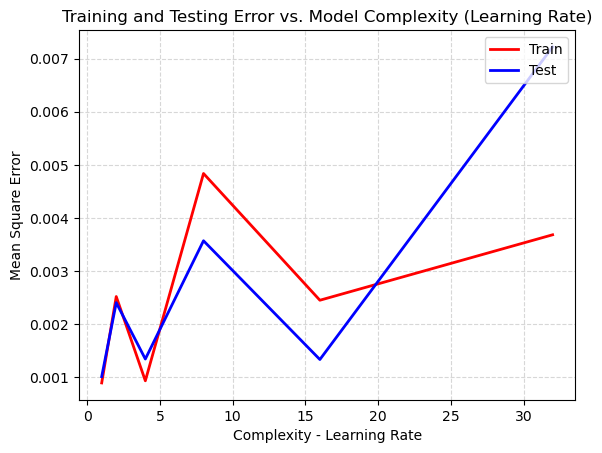

In [ ]:
dropout_rates_summary = mse_summary['batch_sizes']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']

ax = plt.gca()
plt.plot(batch_sizes_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(batch_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(batch_sizes_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(batch_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - Batch Size'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Batch Size)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

plt.show()

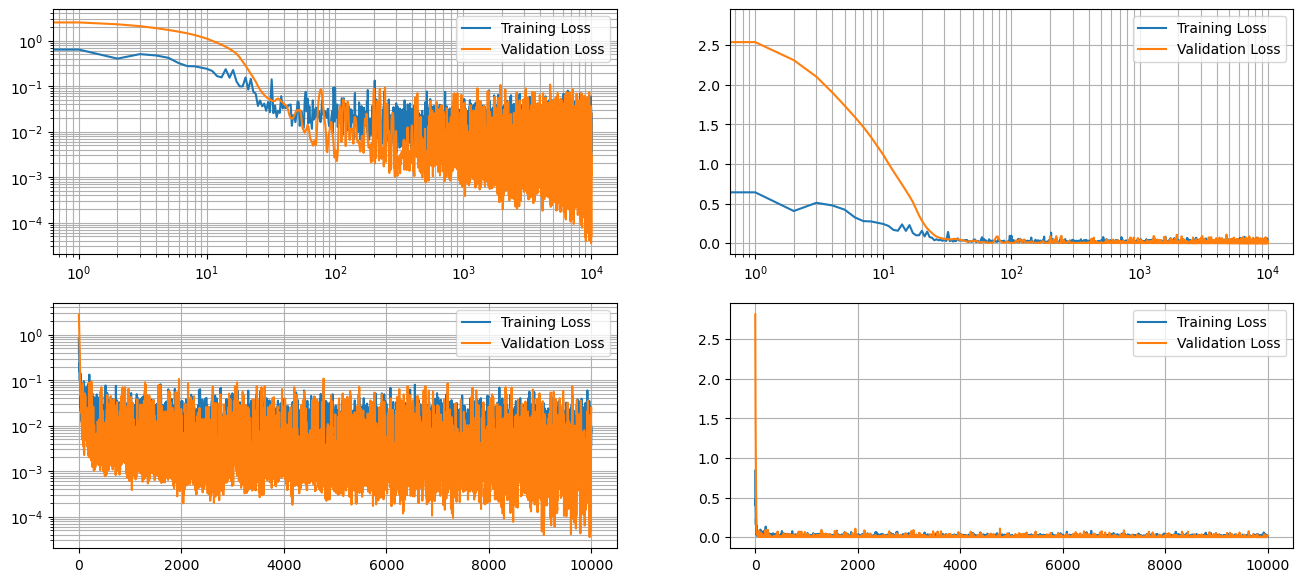

In [ ]:
plt.figure(figsize=(16, 7))
plt.subplot(221)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xscale('log'); plt.yscale('log')
plt.grid(which='both'); plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xscale('log')
plt.grid(which='both'); plt.legend()

plt.subplot(223)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.grid(which='both'); plt.legend()

plt.subplot(224)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid(which='both'); plt.legend()



plt.show()

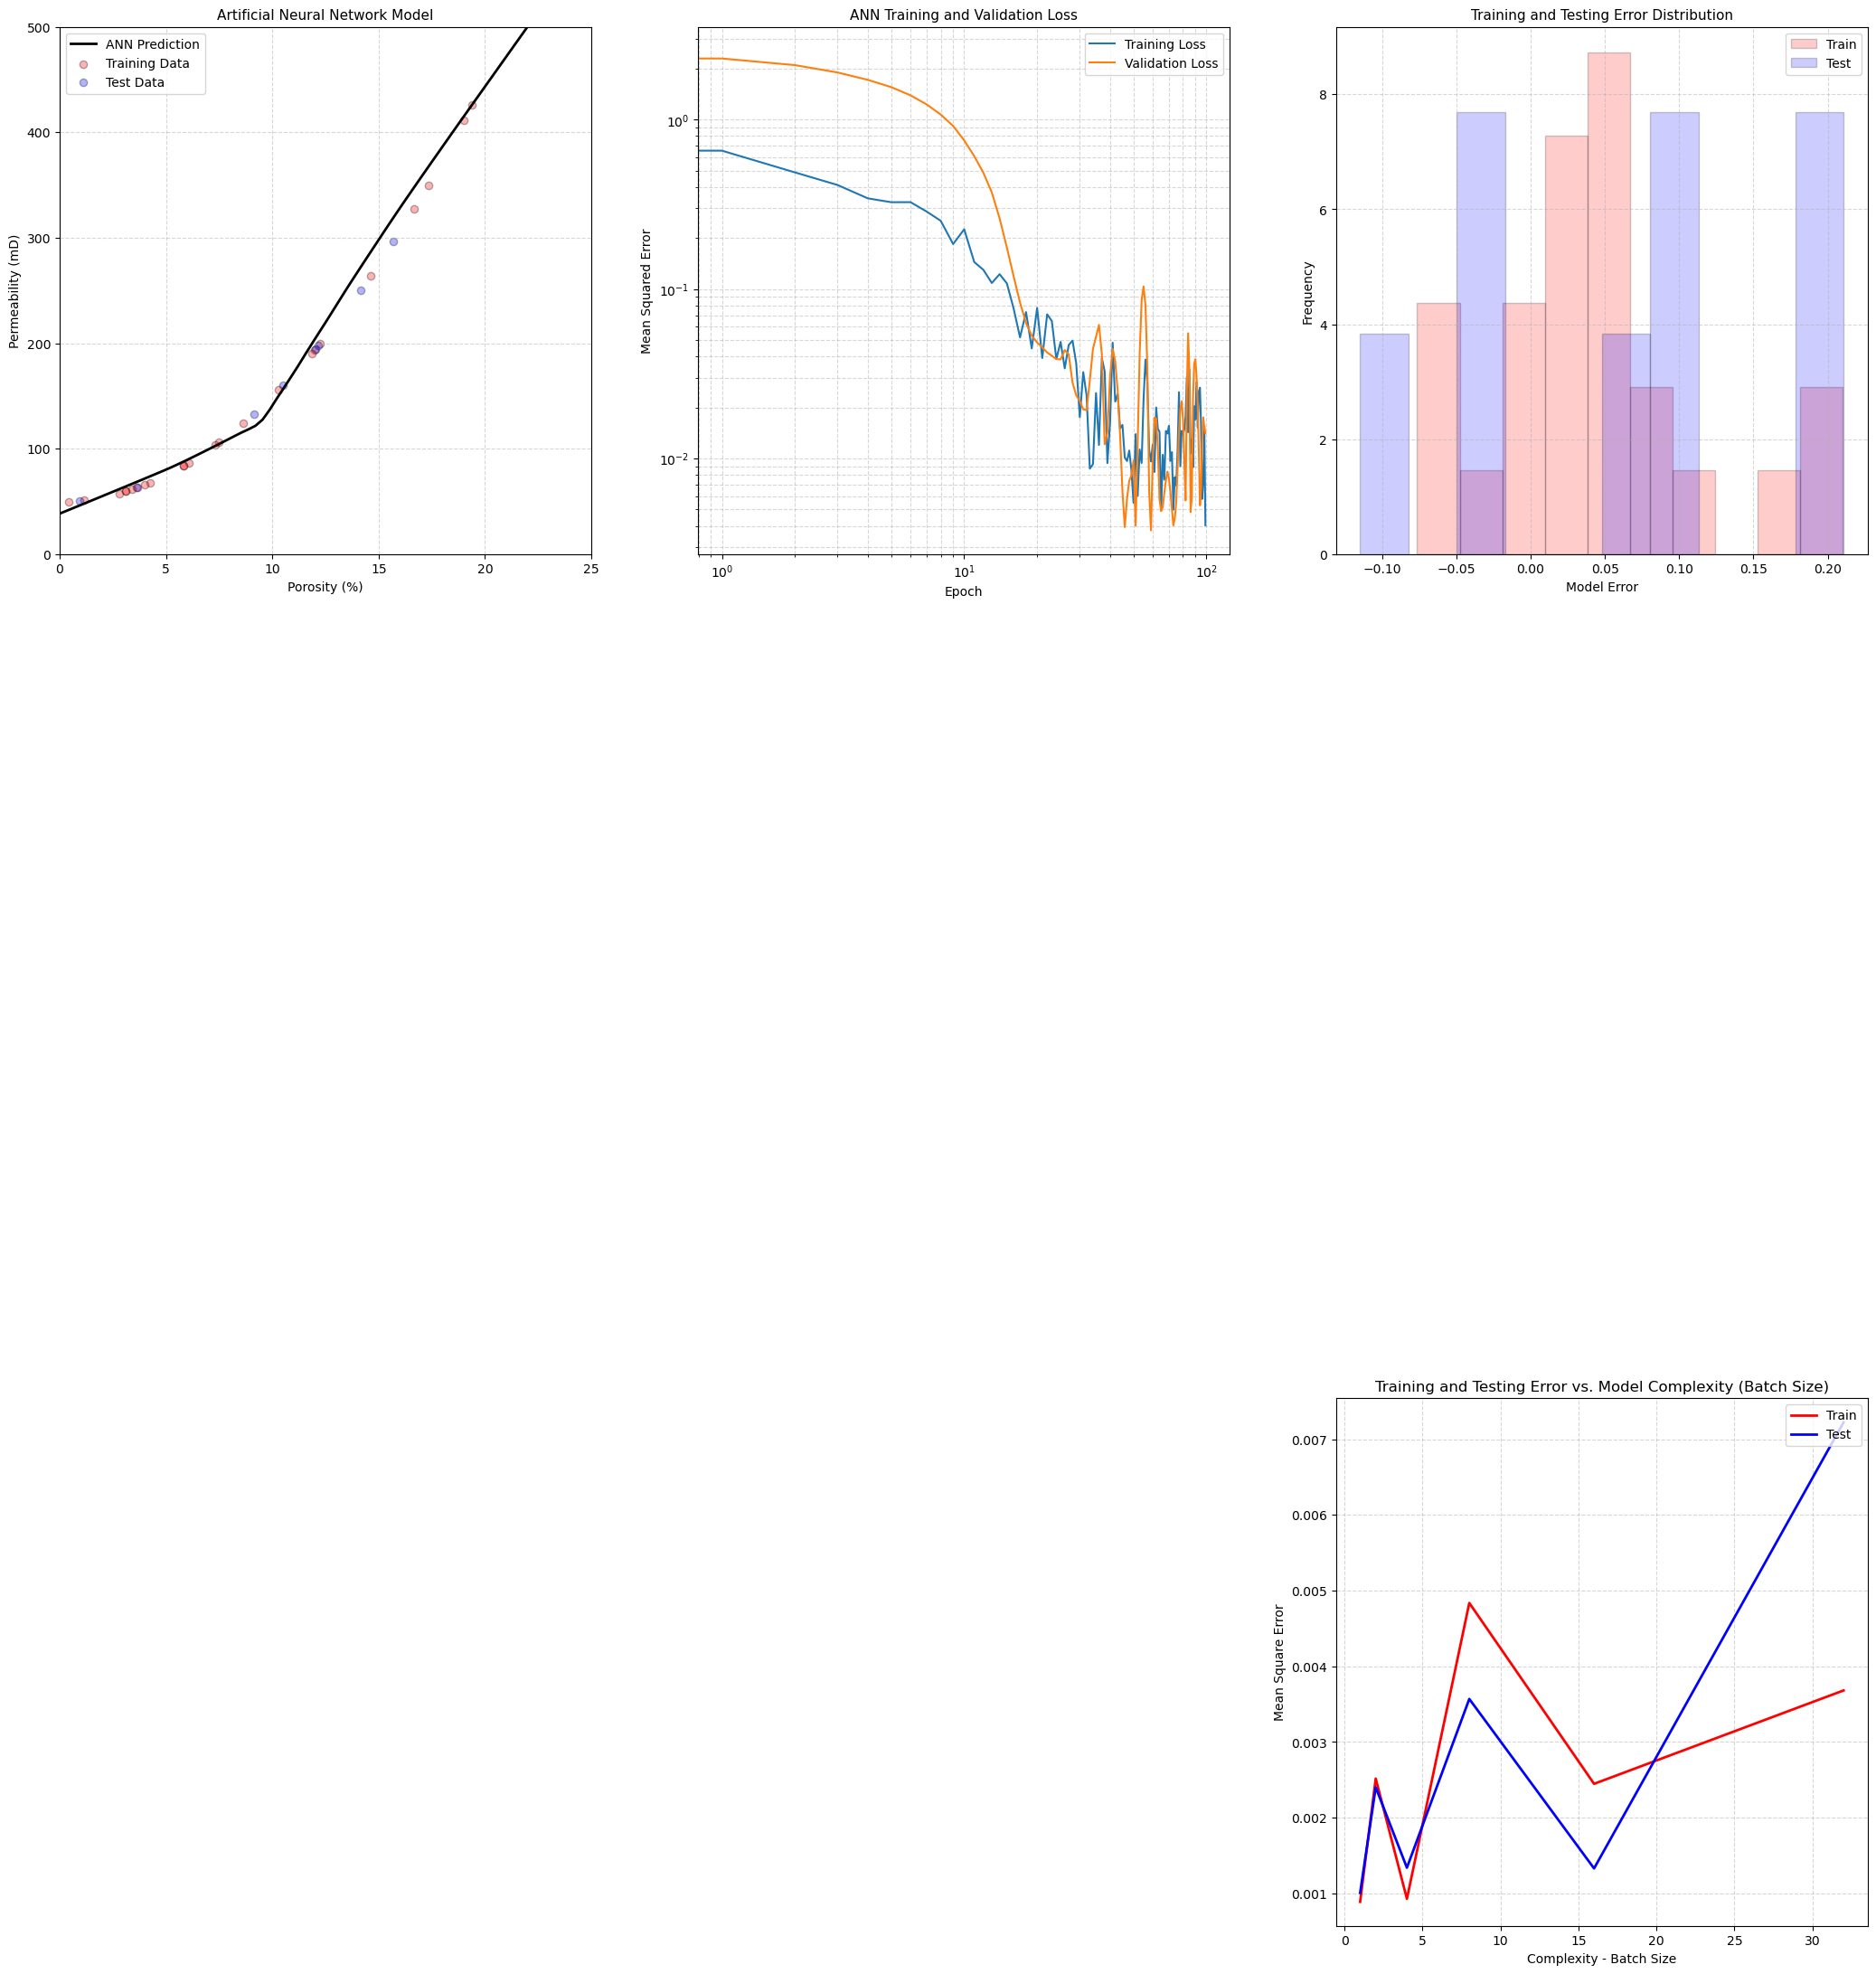

In [ ]:
plt.figure(figsize=(10, 21))
plt.subplot(331)
# Plot model predictions
X_train_true = X_scaler.inverse_transform(X_train.reshape(-1, 1)).flatten()
X_test_true = X_scaler.inverse_transform(X_test.reshape(-1, 1)).flatten()
y_train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
X_seq_true = X_scaler.inverse_transform(X_seq.reshape(-1, 1)).flatten()
y_seq_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
plt.plot(X_seq_true, y_seq_true, color="black", linewidth=2, label="ANN Prediction")
# Plot training and test data
plt.scatter(X_train_true, y_train_true, c="red", alpha=0.3, edgecolors="black", label="Training Data")
plt.scatter(X_test_true, y_test_true, c="blue", alpha=0.3, edgecolors="black", label="Test Data")
plt.title("Artificial Neural Network Model", fontsize=11) # Titles and labels
plt.xlabel("Porosity (%)", fontsize=10); plt.ylabel("Permeability (mD)", fontsize=10)
plt.xlim([0, 25]); plt.ylim([0, 500])
plt.grid(True, linestyle='--', alpha=0.5); plt.legend(frameon=True, loc='upper left')

plt.subplot(332)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ANN Training and Validation Loss", fontsize=11) # Titles and labels
plt.xlabel("Epoch", fontsize=10); plt.ylabel("Mean Squared Error", fontsize=10)
plt.xscale('log'); plt.yscale('log')
plt.grid(which='both',linestyle='--', alpha=0.5); plt.legend()


plt.subplot(333)
plt.hist(error_train, facecolor='red',alpha=0.2,density=True,edgecolor='black',label='Train')
plt.hist(error_test, facecolor='blue',alpha=0.2,density=True,edgecolor='black',label='Test')
plt.xlabel('Model Error', fontsize=10); plt.ylabel('Frequency', fontsize=10); 
plt.title('Training and Testing Error Distribution', fontsize=11)
plt.legend(loc='upper right'); plt.grid(which='both',linestyle='--', alpha=0.5)


plt.subplot(334)
epoch_summary = mse_summary['epochs_list']
train_avg = epoch_summary['train']['mean']; train_high = epoch_summary['train']['high']; train_low = epoch_summary['train']['low']
test_avg = epoch_summary['test']['mean']; test_high = epoch_summary['test']['high']; test_low = epoch_summary['test']['low']
ax = plt.gca()
plt.plot(epochs_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(epochs_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(epochs_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(epochs_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlim([1,10e2]); plt.xscale('log')
plt.ylim([1,10e4]); plt.yscale('log')
plt.xlabel('Complexity - No_of_epochs'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Epochs)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplot(335)
hidden_node_summary = mse_summary['hidden_node_sizes']
train_avg = hidden_node_summary['train']['mean']; train_high = hidden_node_summary['train']['high']; train_low = hidden_node_summary['train']['low']
test_avg = hidden_node_summary['test']['mean']; test_high = hidden_node_summary['test']['high']; test_low = hidden_node_summary['test']['low']
ax = plt.gca()
plt.plot(node_sizes_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(node_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(node_sizes_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(node_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - # Starting Hidden Node'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (# Hidden-Nodes)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplot(336)
num_layers_summary = mse_summary['num_layers']
train_avg = num_layers_summary['train']['mean']; train_high = num_layers_summary['train']['high']; train_low = num_layers_summary['train']['low']
test_avg = num_layers_summary['test']['mean']; test_high = num_layers_summary['test']['high']; test_low = num_layers_summary['test']['low']
ax = plt.gca()
plt.plot(num_layers_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(num_layers_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(num_layers_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(num_layers_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - # Hidden Layers'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (# Hidden-Layers)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplot(337)
dropout_rates_summary = mse_summary['dropout_rates']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
ax = plt.gca()
plt.plot(dropout_rates_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(dropout_rates_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(dropout_rates_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(dropout_rates_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - Dropout Rate'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Dropout Rate)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

plt.subplot(338)
dropout_rates_summary = mse_summary['learning_rates']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
ax = plt.gca()
plt.plot(learning_rates_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(learning_rates_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(learning_rates_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(learning_rates_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Complexity - Learning Rate'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Learning Rate)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)

plt.subplot(339)
dropout_rates_summary = mse_summary['batch_sizes']
train_avg = dropout_rates_summary['train']['mean']; train_high = dropout_rates_summary['train']['high']; train_low = dropout_rates_summary['train']['low']
test_avg = dropout_rates_summary['test']['mean']; test_high = dropout_rates_summary['test']['high']; test_low = dropout_rates_summary['test']['low']
ax = plt.gca()
plt.plot(batch_sizes_list,train_avg,lw=2,label='Train',c='red')
ax.fill_between(batch_sizes_list,train_high,train_low,facecolor='red',alpha=0.05)
plt.plot(batch_sizes_list,test_avg,lw=2,label='Test',c='blue')  
ax.fill_between(batch_sizes_list,test_high,test_low,facecolor='blue',alpha=0.05)
plt.xlabel('Complexity - Batch Size'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity (Batch Size)')
plt.legend(loc='upper right'); plt.grid(which='both', linestyle='--', alpha=0.5)


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.2, hspace=0.3)


plt.show()

In [105]:
history.history['loss'][-1], history.history['val_loss'][-1]

(0.003764960216358304, 0.022638531401753426)

In [124]:

error_train = y_train_pred.flatten() - y_train # calculate error on training data
error_test = y_test_pred.flatten() - y_test # calculate error on test data
error_test


array([-0.00700583, -0.02599027, -0.08685567, -0.00251842,  0.03044743,
        0.12050249,  0.02859403,  0.11604218])

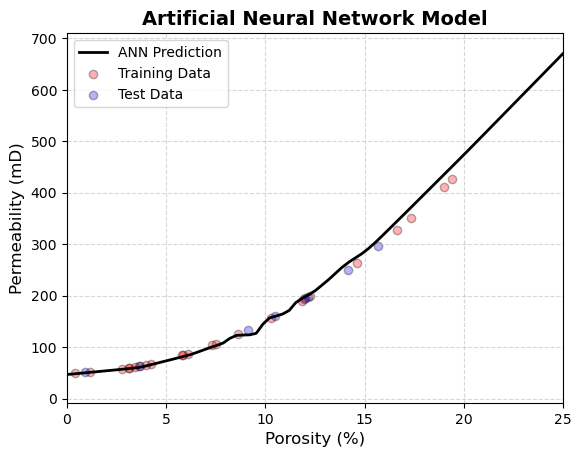

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(11)
# Plot model predictions
X_train_true = X_scaler.inverse_transform(X_train.reshape(-1, 1)).flatten()
X_test_true = X_scaler.inverse_transform(X_test.reshape(-1, 1)).flatten()
y_train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
X_seq_true = X_scaler.inverse_transform(X_seq.reshape(-1, 1)).flatten()
y_seq_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
plt.plot(X_seq_true, y_seq_true, color="black", linewidth=2, label="ANN Prediction")
# Plot training and test data
plt.scatter(X_train_true, y_train_true, c="red", alpha=0.3, edgecolors="black", label="Training Data")
plt.scatter(X_test_true, y_test_true, c="blue", alpha=0.3, edgecolors="black", label="Test Data")
# Titles and labels
plt.title("Artificial Neural Network Model", fontsize=14, fontweight='bold')
plt.xlabel("Porosity (%)", fontsize=12); plt.ylabel("Permeability (mD)", fontsize=12)
# Axes limits and grid
plt.xlim([0, 25]); #plt.ylim([0, 500])
plt.grid(True, linestyle='--', alpha=0.5); plt.legend(frameon=True, loc='upper left')
plt.show()

In [111]:
model.summary()

Model: "sequential_688"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2775 (Dense)              │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2776 (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1402 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2777 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1403 (Dropout)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2778 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,205 (75.02 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,804 (50.02 KB)

In [89]:
model = Sequential()
# Add the input layer
model.add(input_layer(input_nodes, input_activation))
# Add hidden layers
model = create_hidden_layers(model, num_hidden_layers, hidden_nodes, reduce_nodes, hidden_activation, dropout_rate)
# Add the output layer
model.add(output_layer())


opt = Adam(learning_rate=learning_rate)


model.compile(optimizer=opt, loss='mean_squared_error')



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

2/2 - 1s - 314ms/step - loss: 36710.3047


In [70]:
X_seq = np.linspace(0, 20, 100)  # Sequence for plotting
X = np.random.rand(n) * 20  # Generate random X values within the range [0, 20]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).flatten()

In [71]:
X

array([12.66807513, 17.4292118 , 16.07344154,  3.73140118, 17.85117997,
       10.78684484, 16.1488031 , 17.921826  ,  6.3600695 ,  2.20103849,
        4.55870325,  8.54215577, 16.36029532, 17.21461167,  0.13904261,
       10.21494605,  8.34822006,  4.44215621,  2.39730735,  6.75230343,
       18.85819408,  6.46405864, 10.37581243, 14.06037918,  7.27259205,
       19.43564165, 19.2489459 ,  5.03564592,  9.94497012,  6.0175662 ,
        5.69680989,  0.73773895])

In [72]:
X_scaled

array([ 0.43112029,  1.23128098,  1.00342908, -1.07078477,  1.30219731,
        0.11495912,  1.0160944 ,  1.31407015, -0.62900852, -1.32797883,
       -0.93174767, -0.26228524,  1.05163797,  1.1952151 , -1.67451961,
        0.01884532, -0.29487824, -0.95133467, -1.29499371, -0.56308935,
        1.47143697, -0.61153202,  0.04588066,  0.6651121 , -0.4756492 ,
        1.5684833 ,  1.53710705, -0.85159228, -0.02652706, -0.68656992,
       -0.7404765 , -1.5739022 ])

In [ ]:
    # calculate error
 
    error_train = np.polyval(coefs, X_train) - y_train
    #print(np.polyval(coefs, X_train))
    #print('truth')
    #print(X_train)
    error_test = np.polyval(coefs, X_test) - y_test
    
    mse_train = mean_squared_error(y_train, np.polyval(coefs, X_train))
    mse_test = mean_squared_error(y_test, np.polyval(coefs, X_test))
    
    error_train_std = np.std(error_train)
    error_test_std = np.std(error_test)
    
    kde_error_train = scipy.stats.gaussian_kde(error_train)
    kde_error_test = scipy.stats.gaussian_kde(error_test)
    
    plt.subplot(131)
    plt.plot(X_seq, np.polyval(coefs, X_seq), color="black")
    plt.title("Polynomial Model of Degree = "+str(degree))
    plt.scatter(X_train,y_train,c ="red",alpha=0.2,edgecolors="black")
    plt.scatter(X_test,y_test,c ="blue",alpha=0.2,edgecolors="black")
    plt.ylim([0,500]); plt.xlim([0,20]); plt.grid()
    plt.xlabel('Porosity (%)'); plt.ylabel('Permeability (mD)')
    
    plt.subplot(132)
    plt.hist(error_train, facecolor='red',bins=np.linspace(-50.0,50.0,10),alpha=0.2,density=True,edgecolor='black',label='Train')
    plt.hist(error_test, facecolor='blue',bins=np.linspace(-50.0,50.0,10),alpha=0.2,density=True,edgecolor='black',label='Test')
    #plt.plot(error_seq,kde_error_train(error_seq),lw=2,label='Train',c='red')
    #plt.plot(error_seq,kde_error_test(error_seq),lw=2,label='Test',c='blue')   
    plt.xlim([-55.0,55.0]); plt.ylim([0,0.1])
    plt.xlabel('Model Error'); plt.ylabel('Frequency'); plt.title('Training and Testing Error, Model of Degree = '+str((degree)))
    plt.legend(loc='upper left')
    plt.grid(True)
    
    plt.subplot(133); ax = plt.gca()
    plt.plot(cdegrees,cmse_train_avg,lw=2,label='Train',c='red')
    ax.fill_between(cdegrees,cmse_train_high,cmse_train_low,facecolor='red',alpha=0.05)
 
    plt.plot(cdegrees,cmse_test_avg,lw=2,label='Test',c='blue') 
    ax.fill_between(cdegrees,cmse_test_high,cmse_test_low,facecolor='blue',alpha=0.05)
    plt.xlim([1,12]); plt.yscale('log'); plt.ylim([0.0000001,10000])
    plt.xlabel('Complexity - Polynomial Order'); plt.ylabel('Mean Square Error'); plt.title('Training and Testing Error vs. Model Complexity')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    plt.plot([degree,degree],[.0000001,100000],c = 'black',linewidth=3,alpha = 0.8)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.6, wspace=0.2, hspace=0.3)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(run_plot, {'n':n,'split':split,'std':std,'degree':degree})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating


In [ ]:
l = widgets.Text(value='                                       Machine Learning Overfit/Generalization Demo, Prof. Michael Pyrcz and John Eric McCarthy II, The University of Texas at Austin',
                 layout=Layout(width='950px', height='30px'))

n = widgets.IntSlider(min=15, max = 80, value=30, step = 1, description = 'n',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)
split = widgets.FloatSlider(min=0.05, max = .95, value=0.20, step = 0.05, description = 'Test %',orientation='horizontal',style = {'description_width': 'initial'}, continuous_update=False)
std = widgets.FloatSlider(min=0, max = 50, value=0, step = 1.0, description = 'Noise StDev',orientation='horizontal',style = {'description_width': 'initial'}, continuous_update=False)
degree = widgets.IntSlider(min=1, max = 12, value=1, step = 1, description = 'Model Order',orientation='horizontal', style = {'description_width': 'initial'}, continuous_update=False)

ui = widgets.HBox([n,split,std,degree],)
ui2 = widgets.VBox([l,ui],)